# Final project Cloud Platforms
## *Predicting Cab Ride Prices Using Machine Learning*

## Import Libraries & S3

In [52]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [53]:
import boto3
import pandas as pd
import numpy as np
import os
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
import joblib
import tarfile


## Data Loading and Preprocessing

In [54]:
# Initializing S3 Bucket
s3 = boto3.client(
    's3',
    aws_access_key_id='',
    aws_secret_access_key='',
    region_name='us-east-1' 
)
bucket = "taxi-models-group9"

In [55]:
# Load datasets
key = 'datasets/cab_rides.csv'

response = s3.get_object(Bucket=bucket, Key=key)
content = response['Body'].read().decode('utf-8')

rides = pd.read_csv(StringIO(content))

# Load second dataset: Reading
key = 'datasets/weather.csv'

response = s3.get_object(Bucket=bucket, Key=key)
content = response['Body'].read().decode('utf-8')

weather = pd.read_csv(StringIO(content))


### Convert timestamps to datetime format

In [56]:
# Convert with correct units
rides['datetime'] = pd.to_datetime(rides['time_stamp'], unit='ms', errors='coerce')
weather['datetime'] = pd.to_datetime(weather['time_stamp'], unit='s', errors='coerce')

### Round timestamps to the nearest hour

In [57]:
# Round timestamps to the nearest hour
rides['hour'] = rides['datetime'].dt.floor('H')
weather['hour'] = weather['datetime'].dt.floor('H')

### Merge the datasets

In [58]:
# Merge datasets
merged_df = pd.merge(
    rides,
    weather,
    how='left',
    left_on=['source', 'hour'],
    right_on=['location', 'hour']
)


### Drop unnecessary columns

In [59]:
# Drop unused columns
merged_df.drop(['datetime_x', 'datetime_y', 'location', 'time_stamp_y'], axis=1, inplace=True)

### Preview the merged dataset

In [60]:
merged_df.head(5)

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,id,product_id,name,hour,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:00:00,38.46,0.29,1022.25,NaN,0.76,7.68
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:00,44.31,1.00,1003.17,0.1123,0.90,13.69
2,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:00,43.82,0.99,1002.59,0.0997,0.89,11.57
3,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:00:00,35.08,0.00,1013.71,NaN,0.70,5.25


In [61]:
merged_df.isna().sum()

distance                  0
cab_type                  0
time_stamp_x              0
destination               0
source                    0
price                100909
surge_multiplier          0
id                        0
product_id                0
name                      0
hour                      0
temp                   2964
clouds                 2964
pressure               2964
rain                1061692
humidity               2964
wind                   2964
dtype: int64

### Remove rows with missing target values 'can't be trained'

In [62]:

merged_df = merged_df.dropna(subset=['price'])

### Impute missing rain values

In [63]:

merged_df['rain'].fillna(0, inplace=True)


### Impute missing weather values

In [64]:
weather_cols = ['temp', 'humidity', 'pressure', 'clouds', 'wind']
for col in weather_cols:
    merged_df[col].fillna(merged_df[col].median(), inplace=True)


### Check for remaining missing values

In [65]:
merged_df.isna().sum()

distance            0
cab_type            0
time_stamp_x        0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
hour                0
temp                0
clouds              0
pressure            0
rain                0
humidity            0
wind                0
dtype: int64

In [66]:
# Save the full merged & cleaned dataset
merged_df.to_csv('merged_rides_weather.csv', index=False)

### Create a 10% sample of the merged dataset

In [67]:
sample_df = pd.read_csv('merged_rides_weather.csv').sample(frac=0.1, random_state=42)
sample_df

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,id,product_id,name,hour,temp,clouds,pressure,rain,humidity,wind
21928,2.58,Lyft,1544826609864,Theatre District,Northeastern University,22.5,1.0,a0c8bce9-b22c-4584-aea1-924022ea000c,lyft_lux,Lux Black,2018-12-14 22:00:00,40.81,0.94,1028.30,0.0000,0.77,4.98
358548,0.76,Lyft,1544716508840,Haymarket Square,North Station,5.0,1.0,ac4dd57e-4cb4-452b-8124-455adf1d20af,lyft_line,Shared,2018-12-13 15:00:00,26.28,0.52,1033.66,0.0000,0.58,2.83
771715,2.32,Uber,1543776481783,Fenway,Beacon Hill,9.5,1.0,9b97b1ba-9db8-4cf7-b621-1d7d1378f476,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-12-02 18:00:00,48.20,0.99,1006.02,0.0039,0.94,4.08
579168,2.32,Uber,1543827184405,Haymarket Square,Back Bay,20.5,1.0,63835051-b2bb-4c3d-b846-c309c524c292,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03 08:00:00,45.51,0.92,1001.11,0.0000,0.94,2.70
361607,2.52,Lyft,1545097207484,Theatre District,Northeastern University,26.0,1.0,57e1bb8d-38fc-4183-a59b-74e27db01d87,lyft_lux,Lux Black,2018-12-18 01:00:00,36.56,0.54,1001.62,0.0000,0.71,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360497,1.99,Lyft,1543436229300,Theatre District,Northeastern University,16.5,1.0,de3606b1-08af-43ad-b5a1-7260142745c1,lyft_plus,Lyft XL,2018-11-28 20:00:00,41.11,1.00,992.60,0.0000,0.64,9.20
723275,0.55,Uber,1543446129748,South Station,Theatre District,27.0,1.0,aa38facc-4279-42ca-afdc-63506805cdc4,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-28 23:00:00,39.23,0.86,995.96,0.0000,0.66,10.56
265924,2.14,Uber,1543464667668,South Station,West End,15.0,1.0,cbea1d83-04b7-452f-a9c6-f0f50d84c376,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-29 04:00:00,37.74,0.45,998.91,0.0000,0.70,9.37
586105,2.80,Lyft,1543893477401,West End,Fenway,19.5,1.0,e7078d15-2b3a-4a9e-9564-a9dd4706f674,lyft_premier,Lux,2018-12-04 03:00:00,43.90,0.54,1003.17,0.0000,0.63,7.32


### Inspect sample dataset

In [68]:
print(sample_df.info())
print(sample_df.describe())
print(sample_df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 116773 entries, 21928 to 920019
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          116773 non-null  float64
 1   cab_type          116773 non-null  object 
 2   time_stamp_x      116773 non-null  int64  
 3   destination       116773 non-null  object 
 4   source            116773 non-null  object 
 5   price             116773 non-null  float64
 6   surge_multiplier  116773 non-null  float64
 7   id                116773 non-null  object 
 8   product_id        116773 non-null  object 
 9   name              116773 non-null  object 
 10  hour              116773 non-null  object 
 11  temp              116773 non-null  float64
 12  clouds            116773 non-null  float64
 13  pressure          116773 non-null  float64
 14  rain              116773 non-null  float64
 15  humidity          116773 non-null  float64
 16  wind              116

### Visualize the distribution of ride prices

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


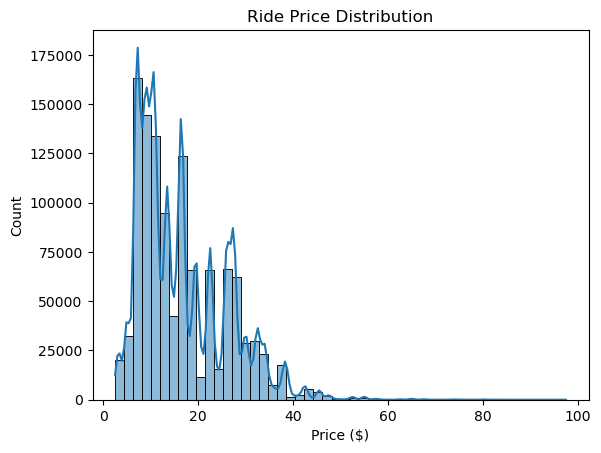

In [69]:
sns.histplot(merged_df['price'], bins=50, kde=True)
plt.title('Ride Price Distribution')
plt.xlabel('Price ($)')
plt.show()


### Explore relationship between rain and ride price

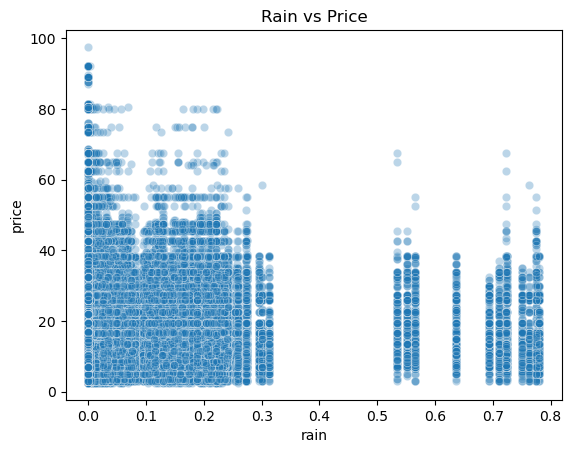

In [70]:
sns.scatterplot(data=merged_df, x='rain', y='price', alpha=0.3)
plt.title('Rain vs Price')
plt.show()


### Analyze ride prices by hour of the day

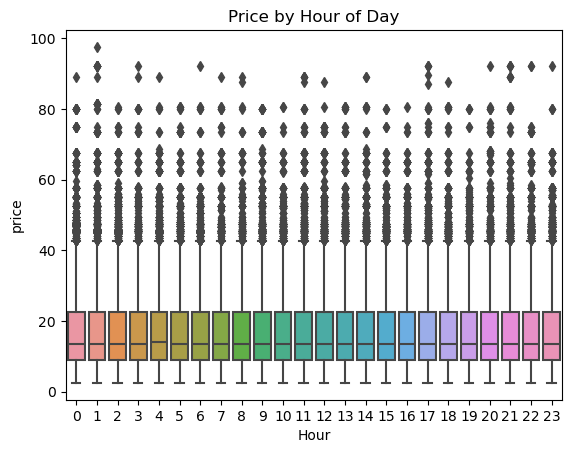

In [71]:
merged_df['hour_only'] = pd.to_datetime(merged_df['hour']).dt.hour

sns.boxplot(data=merged_df, x='hour_only', y='price')
plt.title('Price by Hour of Day')
plt.xlabel('Hour')
plt.show()


## Feature engineering: time and weather-based variables

In [72]:
# Convert 'hour' to datetime (if not already)
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Time-based features
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # 0 = Monday

# Is it rush hour?
merged_df['is_rush_hour'] = merged_df['hour_of_day'].apply(lambda x: 1 if x in [7, 8, 9, 17, 18, 19] else 0)

# Is it raining?
merged_df['is_raining'] = merged_df['rain'].apply(lambda x: 1 if x > 0 else 0)



In [73]:
merged_df.head(5)

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,humidity,wind,hour_only,hour_of_day,day_of_week,is_rush_hour,is_raining
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.29,1022.25,0.0000,0.76,7.68,9,9,6,1,0
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1.00,1003.17,0.1123,0.90,13.69,2,2,1,0,1
2,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.99,1002.59,0.0997,0.89,11.57,2,2,1,0,1
3,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.76,1000.77,0.0000,0.72,8.80,1,1,2,0,0
4,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.00,1013.71,0.0000,0.70,5.25,4,4,4,0,0


### Explore ride types: `product_id` and `name`

In [74]:
print("Unique product_id values:", merged_df['product_id'].nunique())
print("Unique name values:", merged_df['name'].nunique())

print("\nSample product_id values:")
print(merged_df['product_id'].unique()[:5])

print("\nSample name values:")
print(merged_df['name'].unique())


Unique product_id values: 12
Unique name values: 12

Sample product_id values:
['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus']

Sample name values:
['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']


### Filter dataset to include only UberX and Lyft rides

In [75]:
filtered_df = merged_df[merged_df['name'].isin(['UberX', 'Lyft'])]
filtered_df.head(5)


,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,id,product_id,name,...,clouds,pressure,rain,humidity,wind,hour_only,hour_of_day,day_of_week,is_rush_hour,is_raining
3,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.76,1000.77,0.0,0.72,8.80,1,1,2,0,0
22,1.08,Lyft,1543432987778,Northeastern University,Back Bay,7.0,1.0,d859ec69-b3ff-4af8-9abd-441e31430c94,lyft,Lyft,...,1.00,991.83,0.0,0.64,9.45,19,19,2,1,0
23,1.08,Lyft,1543432987778,Northeastern University,Back Bay,7.0,1.0,d859ec69-b3ff-4af8-9abd-441e31430c94,lyft,Lyft,...,1.00,992.59,0.0,0.66,9.88,19,19,2,1,0
24,1.08,Lyft,1543432987778,Northeastern University,Back Bay,7.0,1.0,d859ec69-b3ff-4af8-9abd-441e31430c94,lyft,Lyft,...,1.00,991.92,0.0,0.64,9.50,19,19,2,1,0
27,1.11,Uber,1544728503935,West End,North End,7.5,1.0,357559cb-8c58-4278-a41a-e33b2e0997a3,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,...,0.51,1033.75,0.0,0.57,1.90,19,19,3,1,0


## Saving final dataset in folder in S3 bucket

In [76]:
# Saving final dataset in folder in S3 bucket

csv_buffer = StringIO()
filtered_df.to_csv(csv_buffer, index=False)

# Define your S3 bucket and the object key (path in S3)
bucket =  "taxi-models-group9"
key = "datasets/rides_weather.csv"


# Upload the CSV content to the specified bucket and key
s3.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())

print("✅ rides_weather.csv uploaded to S3 under 'datasets/' folder.")

✅ rides_weather.csv uploaded to S3 under 'datasets/' folder.


### Select features for modeling

In [77]:
features = [
    'distance', 'source', 'temp', 'pressure', 'wind',
    'clouds', 'rain', 'is_raining',
    'hour_of_day', 'day_of_week', 'is_rush_hour'
]



### Prepare data and split for training

In [78]:


# One-hot encode categorical features
X = pd.get_dummies(filtered_df[features], drop_first=True)

# Target variable
y = filtered_df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [79]:
X

,distance,temp,pressure,wind,clouds,rain,is_raining,hour_of_day,day_of_week,is_rush_hour,...,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End
3,0.44,39.61,1000.77,8.80,0.76,0.0,0,1,2,0,...,False,False,False,True,False,False,False,False,False,False
22,1.08,41.09,991.83,9.45,1.00,0.0,0,19,2,1,...,False,False,False,False,False,False,False,False,False,False
23,1.08,40.51,992.59,9.88,1.00,0.0,0,19,2,1,...,False,False,False,False,False,False,False,False,False,False
24,1.08,41.05,991.92,9.50,1.00,0.0,0,19,2,1,...,False,False,False,False,False,False,False,False,False,False
27,1.11,32.75,1033.75,1.90,0.51,0.0,0,19,3,1,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268564,0.91,38.58,997.22,10.10,0.67,0.0,0,1,3,0,...,False,False,False,True,False,False,False,False,False,False
1268565,0.91,38.31,997.47,10.48,0.58,0.0,0,1,3,0,...,False,False,False,True,False,False,False,False,False,False
1268566,0.91,38.34,997.44,10.43,0.59,0.0,0,1,3,0,...,False,False,False,True,False,False,False,False,False,False
1268629,1.61,37.01,1021.65,1.60,0.83,0.0,0,5,6,0,...,False,False,False,False,False,False,False,False,True,False


## Train and evaluate multiple regression models

In [80]:

models = {
    'RandomForest_100': RandomForestRegressor(n_estimators=100, random_state=42),
    'RandomForest_200': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'LinearRegression': LinearRegression()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append((name, mae, rmse))
    print(f"{name} | MAE: ${mae:.2f} | RMSE: ${rmse:.2f}")



RandomForest_100 | MAE: $0.90 | RMSE: $1.53
RandomForest_200 | MAE: $0.93 | RMSE: $1.51
GradientBoosting | MAE: $0.97 | RMSE: $1.56
DecisionTree | MAE: $0.94 | RMSE: $1.54
LinearRegression | MAE: $1.03 | RMSE: $1.62


### Evaluate model performance with additional metrics

In [81]:

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    within_1 = np.mean(np.abs(preds - y_test) < 1)
    within_2 = np.mean(np.abs(preds - y_test) < 2)

    results.append((name, mae, rmse, r2, within_1, within_2))

    print(f"{name}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  R² Score: {r2:.3f}")
    print(f"  Accuracy within $1: {within_1*100:.2f}%")
    print(f"  Accuracy within $2: {within_2*100:.2f}%\n")


RandomForest_100
  MAE: $0.90
  RMSE: $1.53
  R² Score: 0.628
  Accuracy within $1: 70.43%
  Accuracy within $2: 89.38%

RandomForest_200
  MAE: $0.93
  RMSE: $1.51
  R² Score: 0.637
  Accuracy within $1: 69.30%
  Accuracy within $2: 91.75%

GradientBoosting
  MAE: $0.97
  RMSE: $1.56
  R² Score: 0.610
  Accuracy within $1: 66.94%
  Accuracy within $2: 91.10%

DecisionTree
  MAE: $0.94
  RMSE: $1.54
  R² Score: 0.622
  Accuracy within $1: 67.56%
  Accuracy within $2: 91.28%

LinearRegression
  MAE: $1.03
  RMSE: $1.62
  R² Score: 0.581
  Accuracy within $1: 61.65%
  Accuracy within $2: 90.35%



## Hyperparameter tuning using GridSearchCV

Randomforest200 seems to work well, but we decided to perform a gridsearch to optimize the model

In [82]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  24.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  24.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  28.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  28.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  28.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  25.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  56.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  57.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  58.2s
[CV] END max_depth=No

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  21.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  10.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  20.9s
[CV] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=200; total time=  52.2s
[CV] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100; total time=  10.7s
[CV] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100; total time=  11.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  21.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  21.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  21.1

In [83]:
# Original RF_200
rf_200 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_200.fit(X_train, y_train)
pred_200 = rf_200.predict(X_test)

# Tuned model from GridSearchCV
best_params = grid.best_params_
rf_tuned = RandomForestRegressor(**best_params, random_state=42)
rf_tuned.fit(X_train, y_train)
pred_tuned = rf_tuned.predict(X_test)


### Define a reusable evaluation function

In [84]:
def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    within_1 = np.mean(np.abs(y_pred - y_true) < 1)
    within_2 = np.mean(np.abs(y_pred - y_true) < 2)
    print(f"{name}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  R²: {r2:.3f}")
    print(f"  Accuracy within $1: {within_1*100:.2f}%")
    print(f"  Accuracy within $2: {within_2*100:.2f}%\n")




### Compare final 2 models

In [85]:
evaluate("RandomForest_200", y_test, pred_200)
evaluate("Tuned RandomForest", y_test, pred_tuned)

RandomForest_200
  MAE: $0.89
  RMSE: $1.52
  R²: 0.630
  Accuracy within $1: 70.67%
  Accuracy within $2: 89.44%

Tuned RandomForest
  MAE: $0.95
  RMSE: $1.53
  R²: 0.625
  Accuracy within $1: 68.49%
  Accuracy within $2: 90.78%



In [86]:
best_model = models['RandomForest_200']

## Saving result in S3 Bucket

In [87]:
import os
import joblib
import tarfile
import boto3
from sklearn.metrics import r2_score, mean_squared_error

# === 1. Save model to local temp directory ===
local_dir = "temp_output"
os.makedirs(local_dir, exist_ok=True)

model_path = os.path.join(local_dir, "RandomForest_200_taxi.joblib")
report_path = os.path.join(local_dir, "model_report.txt")
tar_path = os.path.join(local_dir, "model_bundle.tar.gz")

# Save trained model
joblib.dump(best_model, model_path)

# Optional: evaluation report (edit y_test, y_pred if available)
with open(report_path, "w") as f:
    f.write("✅ Model Report\n")
    f.write("Model: RandomForestRegressor (200 trees)\n")
    # Uncomment and fill in actual test results if you have them
    # f.write(f"R² Score: {r2_score(y_test, y_pred):.4f}\n")
    # f.write(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}\n")

# === 2. Create tar.gz file of the model (for SageMaker) ===
with tarfile.open(tar_path, "w:gz") as tar:
    tar.add(model_path, arcname="RandomForest_200_taxi.joblib")

# === 3. Upload to S3 ===
s3 = boto3.client(
    "s3",
    aws_access_key_id='',
    aws_secret_access_key=''
    region_name='us-east-1'
)

bucket = "taxi-models-group9"

s3.upload_file(model_path, bucket, "output/RandomForest_200_taxi.joblib")
s3.upload_file(report_path, bucket, "output/model_report.txt")
s3.upload_file(tar_path, bucket, "output/model_bundle.tar.gz")

print("✅ Model, report, and archive uploaded to S3!")


✅ Model, report, and archive uploaded to S3!


## Create some actionable insights based on tomorrows weather in Bosten

*create a dataframe for every hour for each neighbourhood.*
- Weather is from: https://www.accuweather.com/en/us/boston/02108/hourly-weather-forecast/348735?day=2
- pressure wasn't given so is kept constant at 1012
- distance is set at 10 miles


In [88]:
import pandas as pd

# Actual data of Boston tomorrow
data = [
    {"hour_of_day": 0, "temp": 3, "wind": 11, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 51, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 1, "temp": 3, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 54, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 2, "temp": 2, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 55, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 3, "temp": 1, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 56, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 4, "temp": 1, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 56, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 5, "temp": 1, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 57, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 6, "temp": -1, "wind": 7, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 62, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 7, "temp": 0, "wind": 7, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 62, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 8, "temp": 1, "wind": 7, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 63, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 9, "temp": 3, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 64, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 10, "temp": 5, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 60, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 11, "temp": 6, "wind": 9, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 61, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 12, "temp": 7, "wind": 11, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 61, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 13, "temp": 8, "wind": 15, "clouds": 0, "rain": 0, "is_raining": 0, "humidity": 60, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 14, "temp": 8, "wind": 15, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 58, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 15, "temp": 9, "wind": 17, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 58, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 16, "temp": 8, "wind": 17, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 57, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 17, "temp": 8, "wind": 17, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 56, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 18, "temp": 8, "wind": 17, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 55, "day_of_week": 3, "is_rush_hour": 1, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 19, "temp": 7, "wind": 17, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 53, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 20, "temp": 7, "wind": 15, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 53, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 21, "temp": 6, "wind": 13, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 57, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 22, "temp": 6, "wind": 13, "clouds": 100, "rain": 0, "is_raining": 0, "humidity": 61, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1},
    {"hour_of_day": 23, "temp": 5, "wind": 13, "clouds": 100, "rain": 1, "is_raining": 1, "humidity": 51, "day_of_week": 3, "is_rush_hour": 0, "distance": 10.0, "pressure": 1012, "source_Back Bay": 1}
]

df_base = pd.DataFrame(data)

# Step 2: Define all district one-hot columns
source_districts = [
    'source_Back Bay', 'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
    'source_Financial District', 'source_Haymarket Square', 'source_North End',
    'source_North Station', 'source_Northeastern University', 'source_South Station',
    'source_Theatre District', 'source_West End'
]

# Step 3: Create 1 row for each district with its one-hot encoding
district_rows = []
for district in source_districts:
    row = {d: 0 for d in source_districts}
    row[district] = 1
    district_rows.append(row)

df_districts = pd.DataFrame(district_rows)

# Step 4: Remove hardcoded Back Bay column from base data
df_base = df_base.drop(columns=source_districts, errors="ignore")

# Step 5: Create cartesian product (24 hours × 12 districts = 288 rows)
df_base['key'] = 1
df_districts['key'] = 1
df_all = pd.merge(df_base, df_districts, on='key').drop(columns='key')

# ✅ df_all now has all hours for all districts
print(df_all.shape)  # (288, features)

(288, 23)


### Make predictions using Best_model

In [89]:
df_model_input = df_all[best_model.feature_names_in_]
df_all["predicted_price"] = best_model.predict(df_model_input)
df_all["price_per_mile"] = df_all["predicted_price"] / df_all["distance"]



In [90]:
# List of one-hot encoded district columns
source_columns = [
    'source_Back Bay', 'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
    'source_Financial District', 'source_Haymarket Square', 'source_North End',
    'source_North Station', 'source_Northeastern University', 'source_South Station',
    'source_Theatre District', 'source_West End'
]

# Extract readable source name
df_all["source"] = df_all[source_columns].idxmax(axis=1).str.replace("source_", "")


In [91]:
df_all[["hour_of_day", "source", "predicted_price", "price_per_mile"]].to_csv("taxi_predictions_clean.csv", index=False)




### Show what district gives the highest price per hour

In [92]:
best_districts = (
    df_all.loc[
        df_all.groupby("hour_of_day")["price_per_mile"].idxmax()
    ][["hour_of_day", "source", "price_per_mile"]]
    .reset_index(drop=True)
)

print(best_districts)



    hour_of_day             source  price_per_mile
0             0             Fenway        1.748569
1             1  Boston University        1.856265
2             2  Boston University        1.868020
3             3  Boston University        1.870808
4             4  Boston University        1.871795
5             5  Boston University        1.874500
6             6  Boston University        1.882417
7             7  Boston University        1.883125
8             8  Boston University        1.884500
9             9  Boston University        1.880612
10           10  Boston University        1.882988
11           11  Boston University        1.884427
12           12  Boston University        1.767274
13           13  Boston University        1.782471
14           14             Fenway        1.846715
15           15             Fenway        1.843996
16           16             Fenway        1.821569
17           17             Fenway        1.821069
18           18             Fen

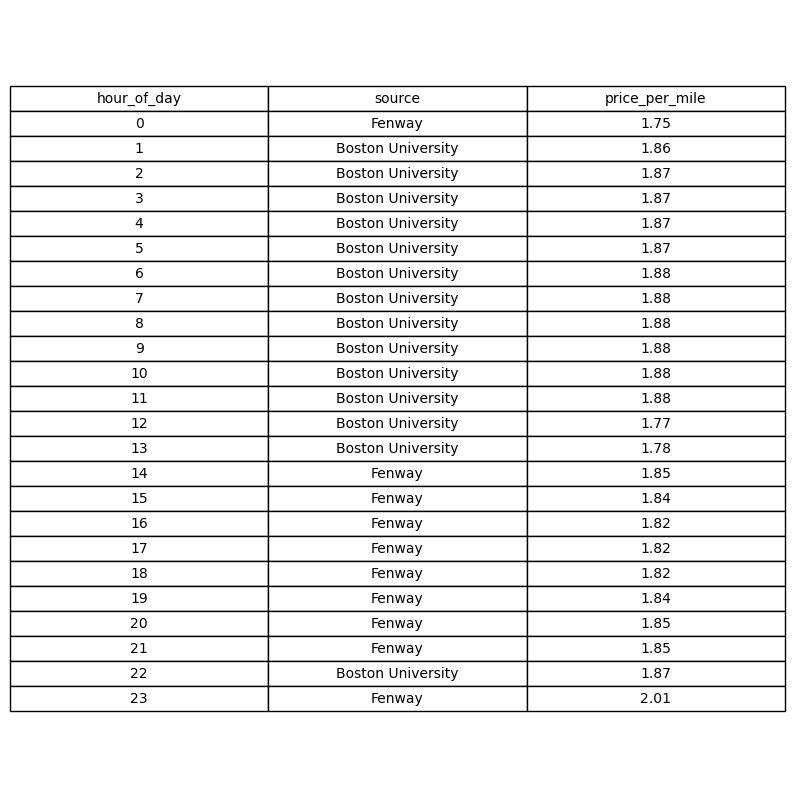

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Round the price column to 2 decimals
best_districts_rounded = best_districts.copy()
best_districts_rounded['price_per_mile'] = best_districts_rounded['price_per_mile'].round(2)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 0.5 + 0.4 * len(best_districts_rounded)))
ax.axis('off')

# Plot the table
tbl = ax.table(
    cellText=best_districts_rounded.values,
    colLabels=best_districts_rounded.columns,
    loc='center',
    cellLoc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Save as PNG
plt.savefig("best_districts_table.png", bbox_inches="tight", dpi=300)





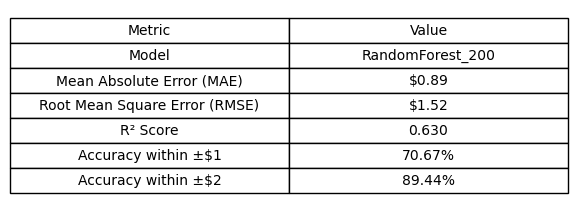

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
metrics = {
    "Metric": [
        "Model",
        "Mean Absolute Error (MAE)",
        "Root Mean Square Error (RMSE)",
        "R² Score",
        "Accuracy within ±$1",
        "Accuracy within ±$2"
    ],
    "Value": [
        "RandomForest_200",
        "$0.89",
        "$1.52",
        "0.630",
        "70.67%",
        "89.44%"
    ]
}

df_metrics = pd.DataFrame(metrics)

# Display as a table and save to image
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis('off')
table = ax.table(
    cellText=df_metrics.values,
    colLabels=df_metrics.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Save as PNG
plt.savefig("model_performance_table.png", bbox_inches="tight", dpi=300)
